# prior_box匹配、分类、回归情况统计

## 统计流程：
1. 调用convert_annoset.exe生成样本列表

2. 调用caffe.exe生成匹配列表

3. 合并匹配列表和样本列表

4. 调用test_ssd.exe生成检测结果列表

5. 比较prior box训练前后分类、回归结果
```
caffe-master_/
    Pedestrian/
        Data_0810/
            train_lmdb_list.txt
            IOU_ALL.txt
            IOU_ALL_image_List.txt
            result_ALL_image_List.txt
        CHECK/
            priorVSgt_bar.py
            merge_IOU_image_List.py
            IOU_change_curve.py
            confidence_change_curve.py
            object_confidence_IOU_change_curve.py
    windows/
        caffe/
            check.txt
        convert_annoset/
        test_SSD/
            result.txt
```

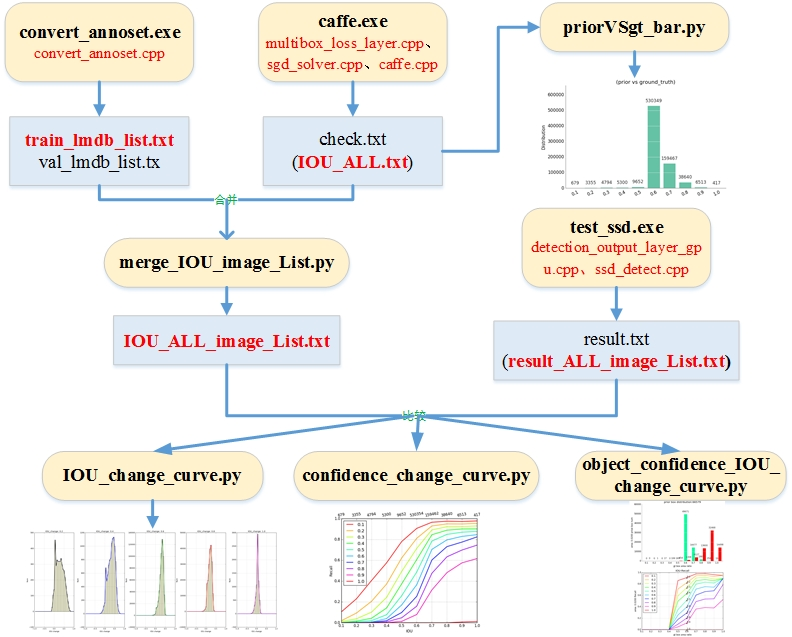

In [15]:
from IPython.display import Image
Image(filename='匹配统计.jpg')

## 1 获取待匹配列表

### 1.1 db文件列表保存
由于样本转db文件时会shuffle样本的顺序，因此我们需要在样本转db文件时保存shuffle后的列表顺序。添加的代码段在caffe的 convert_annoset.cpp 文件中，由**BOX_LIST**宏包围。利用批处理脚本 CovertDataAnn.bat 调用 convert_annoset.exe运行结束后会在生成的db文件所在目录下生成 **<font color='red'>train_lmdb_list.txt</font>** 和 val_lmdb_list.txt 两个样本列表文件。列表格式为：
**<font color='green'>$"image\_path" \quad "xml\_path"$</font>**

### 1.2 prior box与ground truth box匹配结果保存
为了获得匹配结果，需要利用caffe训练一次所有样本，同时记录下样本的匹配结果。caffe中添加的代码分别在multibox_loss_layer.cpp、sgd_solver.cpp、caffe.cpp中，由**BOX_LIST**宏包围。其中在multibox_loss_layer.cpp中可以设置保存所有匹配结果还是保存$IOU<0.5$的匹配结果：

const char* model = "all"; // 选择只统计$IOU<0.5$的bbox还是统计全部匹配：small / all

训练前，需配置好训练prototxt。首先，需计算solver.prototxt中max_iter大小以保证所有样本应该只完成一次迭代训练，计算公式为max_iter = round_up（num_of_train_samples / batch_size）。由于计算结果上向上取整，所以存在少量样本迭代了两次，可在生成的列表中将列表末尾对比列表开头以删除重复的匹配。其次，需要将train.prototxt中所有的样本图像处理和增广处理去掉。

批处理脚本squeezeNet_train.bat调用 caffe.exe 训练结束后会在程序运行所在目录 $\\caffe$ 下生成**<font color='red'>check.txt</font>**列表文件。列表格式为：
<font color='green'>$"status" \quad "prior\_with\_gt\_IOU"\quad "prior\_box\_index"\quad "prior\_box\_cordinates"\quad "batch\_index"\quad  "index\_of\_one\_batch"\quad "gt\_box\_index"$</font>

这里简单描述下列表保存过程：训练一开始会检查**check.txt**是否存在，如果存在删除。进入每个batch后，将这个batch中每个样本的匹配情况写入临时文件**temp.txt**。然后结合batch信息$batch\_index$将匹配情况以追加模式重写入**check.txt**并删除临时文件**temp.txt**。

## 2 匹配结果合并

### 2.1 统计绘制匹配直方图
将上面训练生成的check.txt复制到db文件所在目录，全部匹配列表重命名为**<font color='red'>IOU_ALL.txt</font>**，$IOU<0.5$的匹配列表重命名为IOU_small.txt。接下来绘制匹配结果直方图。绘制代码为 $\\CHECK$ 文件夹下**<font color='red'>priorVSgt_bar.py</font>**。从直方图中我们可以观察出各个IOU区间段box匹配情况。

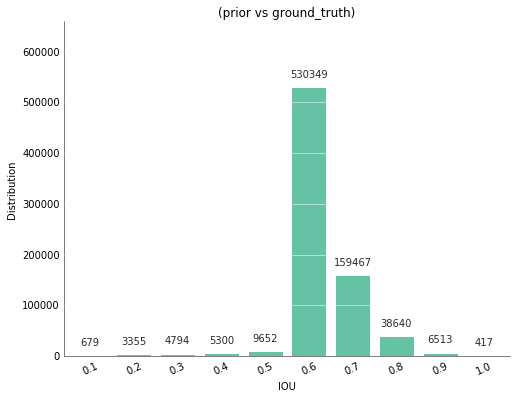

In [9]:
# %load priorVSgt_bar.py
import numpy as np
import pylab as plt
import matplotlib
import prettyplotlib as ppl

thresholds = np.linspace( 0.1, 1, 10 ) # 分段阈值
s_ids = np.arange(thresholds.size)
group = np.zeros(thresholds.size,dtype=np.int32)

"""
@function:绘制所有IOU区间段的匹配数量直方图
@param param1: 匹配列表
"""
def draw_curve(dataList):
    for data in open(dataList).readlines():  # 对于每个数据
        IOU = float(data.strip().split(' ')[1])
        for i in s_ids:
            if (IOU < thresholds[i]):
                group[i] += 1
                break
    matplotlib.rcParams['figure.figsize'] = (8, 6)  # 设定显示大小
    fig, ax = plt.subplots(1)
    labels = [thresholds[i] for i in s_ids]
    anno_area2s = [('%d' % a) for a in group[s_ids]]
    ppl.bar(ax, np.arange(len(group)), group[s_ids], annotate=anno_area2s, grid='y', xticklabels=labels)
    plt.xticks(rotation=25)
    ax.set_title('(prior vs ground_truth)')
    ax.set_xlabel('IOU')
    ax.set_ylabel('Distribution')
    plt.savefig('../Data_0810/priorVSgt.png')
    plt.show()

if __name__ == "__main__":
    draw_curve("../Data_0810/IOU_ALL.txt")

### 2.2 匹配合并
通过匹配结果中的<font color='green'>$"batch\_index"\quad "index\_of\_one\_batch"$</font>可以将匹配结果（IOU_ALL.txt）与样本列表（train_lmdb_list.txt）进行合并。合并代码为**<font color='red'>merge_IOU _image_List.py</font>**，代码运行结束后会生成**<font color='red'>IOU_ALL_image_List.txt</font>**合并列表。

合并后列表格式为：<font color='green'>$"image\_name"\quad "xml\_name"\quad "prior\_boxes\_total"\quad ""prior\_box1\_index"\quad "box1\_IOU"\quad "box1\_coordinates"\quad "gt\_box\_index" ..."$</font>

获得合并列表后，可以直接显示列表中的box匹配情况：

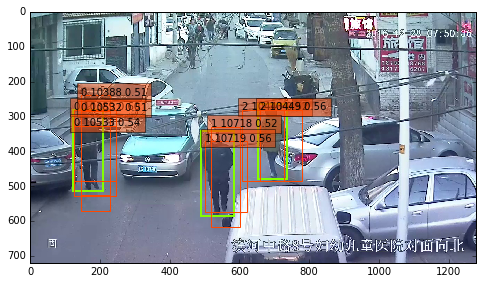

In [17]:
# %load merge_IOU_image_List.py
import numpy as np
import xml.etree.cElementTree as et
import matplotlib.pyplot as plt
import linecache

"""
@function:计算两个box的IOU
@param param1: box1
@param param2: box2
@return: IOU
"""
def computIOU(A, B):
    W = min(A[2], B[2]) - max(A[0], B[0])
    H = min(A[3], B[3]) - max(A[1], B[1])
    if (W <= 0 or H <= 0):
        return 0
    SA = (A[2] - A[0]) * (A[3] - A[1])
    SB = (B[2] - B[0]) * (B[3] - B[1])
    cross = W * H
    iou = float(cross) / (SA + SB - cross)
    return iou

"""
@function:从xml文件中读取box信息
@param param1: xml文件
@return: boxes
"""
def readXML(xml_name):
    tree = et.parse(xml_name) #打开xml文档
    # 得到文档元素对象
    root = tree.getroot()
    size = root.find('size')  # 找到root节点下的size节点
    # width = size.find('width').text  # 子节点下节点width的值
    # height = size.find('height').text  # 子节点下节点height的值

    boundingBox = []
    for object in root.findall('object'):  # 找到root节点下的所有object节点
        bndbox = object.find('bndbox')  # 子节点下属性bndbox的值
        xmin = bndbox.find('xmin').text
        ymin = bndbox.find('ymin').text
        xmax = bndbox.find('xmax').text
        ymax = bndbox.find('ymax').text
        boundingBox.append([int(xmin), int(ymin), int(xmax), int(ymax)])
    return boundingBox

"""
@function:将匹配结果按照训练顺序和训练样本名进行合并
@param param1: 匹配列表文件
@param param2: 样本列表文件
@param param3: 待合并输出列表文件
"""
def copyList(IOUList, imageList, outList):
    imageData = open(imageList)
    lines_num = len(imageData.readlines())
    imageTmp = ''
    dataALL = []
    totalNum = 0
    for IOUdata in open(IOUList).readlines():  # 对于每个匹配数据
        datas = IOUdata.strip().split(' ')
        # if float(datas[1]) < 0.5: # 如果只统计IOU<0.5的匹配
        totalNum += 1
        num = (int(datas[7])* batch_size) + int(datas[8]) + 1 # 按照batch 索引和数据在batch中索引计算对应的样本索引
        # 由于样本总数lines_num除以batch_size可能是个小数，导致生成的IOUList里存在少量迭代两轮的样本
        # 而又因为每个batch是按照imageList顺序取得，所以如果IOUList中计算得到的索引num大于样本总数，则停止统计
        if num > lines_num :
            break

        theline = linecache.getline(imageList, num).strip().split('\t') # 对应的样本名数据
        # 因为一个样本中有多个匹配数据，我们要将属于同一个样本的匹配数据按顺序放入dataALL
        if imageTmp!=theline[0] : # 如果前后两次样本不相同
            totalNum = 1
            dataALL.append([theline[0], theline[1], str(totalNum), datas[2], datas[1], datas[3], datas[4], datas[5], datas[6], datas[9]])
            totalNum = 0
            imageTmp = theline[0]
        else:                    # 如果前后两次样本相同
            dataALL[-1][2] = str(int(dataALL[-1][2])+1)
            dataALL[-1] = dataALL[-1] + [datas[2], datas[1], datas[3], datas[4], datas[5], datas[6], datas[9]]
            imageTmp = theline[0]
        # else:
        #     continue
    fout = file(outList, "w+")
    for newData in dataALL:
        fout.write((newData[0] + '\t' + newData[1] + '\t' + newData[2]));
        for i in range(0,int(newData[2]),1):
            fout.write('\t')
            fout.write((newData[7*i + 3] + '\t' + newData[7*i + 4] + '\t' + newData[7*i + 5] + '\t'
                        + newData[7 * i + 6] + '\t' + newData[7 * i + 7]  + '\t' + newData[7 * i + 8]
                        + '\t' + newData[7 * i + 9] ))
        fout.write('\n')
    fout.close()

"""
@function:将匹配合并结果显示，红色框是ground truth box, 绿色框是 prior box
@param param1: 合并输出列表文件
"""
def showList(IOU_small_List):
    for boxData in open(IOU_small_List).readlines():  # 对于每个box
        data = boxData.strip().split('\t')
        full_image_path = ROOTDIR + data[0]
        img = plt.imread(full_image_path)
        plt.imshow(img)
        currentAxis = plt.gca()
        width = img.shape[1]
        height = img.shape[0]
        full_xml_path = ROOTDIR + data[1]
        true_boxes = readXML(full_xml_path)
        print full_xml_path.decode("gb2312")

        for boxT in true_boxes:
            currentAxis.add_patch(plt.Rectangle((boxT[0], boxT[1]), boxT[2] - boxT[0], boxT[3] - boxT[1],
                                                fill=False, edgecolor=colors[5], linewidth=2))
        # 检查下IOU_small_List中box与样本中能否对应的上
        boxes_total = int(data[2])
        for i in range(0, boxes_total, 1):
            databox_num = int(data[7*i + 9])
            display_txt = '%d %d %.2f' % ( float(data[7*i + 9]), float(data[7*i + 3]), float(data[7*i + 4]))
            databox = [float(data[7*i + 5]) * width, float(data[7*i + 6]) * height, float(data[7*i + 7]) * width, float(data[7*i + 8]) * height]
            currentAxis.add_patch(plt.Rectangle((databox[0], databox[1]), databox[2] - databox[0], databox[3] - databox[1],
                                                 fill=False, edgecolor=colors[1], linewidth=1))
            currentAxis.text(databox[0], databox[1], display_txt, bbox={'facecolor': colors[1], 'alpha': 0.5})
        plt.show()
        break
    print "end"

batch_size = 32
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist() # 颜色列表
ROOTDIR = "\\\\192.168.1.186/PedestrianData/" # 样本根目录

if __name__ == "__main__":
    copyList("../Data_0810/IOU_ALL.txt", "../Data_0810/train_lmdb_list.txt", "../Data_0810/IOU_ALL_image_List.txt")
    showList("../Data_0810/IOU_ALL_image_List.txt")

## 3 检查训练中prior box分类、回归情况
这里，我们要调查的是不同的大小的匹配IOU对于prior box匹配分类和回归的影响。

### 3.1 检测结果保存
这一步我们利用训练好的模型对所有训练样本进行一次预测，保存prior box经过回归后的坐标和经过分类后的置信度信息。caffe中添加的代码分别在detection_output_layer_gpu.cpp、ssd_detect.cpp中，由**BOX_LIST**宏包围。批处理脚本Test_ssd.bat调用test_ssd.exe检测IOU_ALL_image_List.txt中每个样本，结束后会在**$test_SSD$**工程目录下生成**<font color='red'>result.txt</font>**列表文件。

列表格式为：
<font color='green'>$"img\_name"\quad ""prior\_box1\_index"\quad "prior\_box1\_coordinates"\quad "confidence"..."$</font>

这里简单描述下列表该保存过程：程序开头会检查result.txt是否存在，若存在则删除。对于IOU_ALL_image_List.txt中每个样本，生成临时文件temp.txt以保存该样本中所有prior box index。检测代码中原本的非极大值抑制过程会筛选检测结果，这里直接将检测目标索引替换成临时文件temp.txt中prior box index并删除temp.txt。最后以追加模式将检测结果存入result.txt。

得到result.txt后，将其拷贝到db文件所在文件夹，重命名为**<font color='red'>result_ALL_image_List.txt</font>**。

### 3.2 绘制prior box回归直方图
**<font color='red'>IOU_change_curve.py</font>**中统计了各个匹配IOU区间段里prior boxes的回归情况，并绘制直方图。程序将IOU_ALL_image_List.txt列表中的prior boxes、gt box信息和result_ALL_image_List.txt列表中的通过检测网络后变化的prior boxes读取出来。因为这两个列表的顺序是完全一致的，因此可以很容易计算prior boxes的IOU变化。然后按照不同的初始IOU所在区间段将IOU变化保存成**<font color='red'>IOU_change_curve.mat</font>**文件。最后读取mat文件绘制IOU变化直方图。

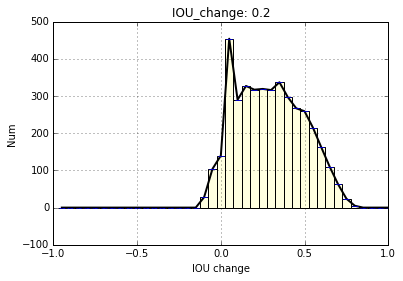

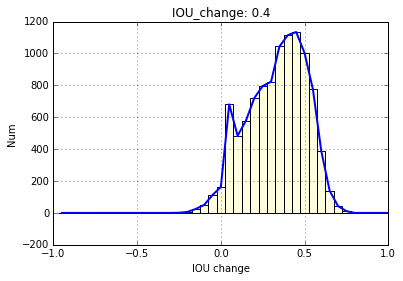

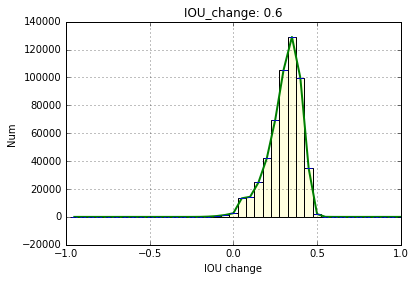

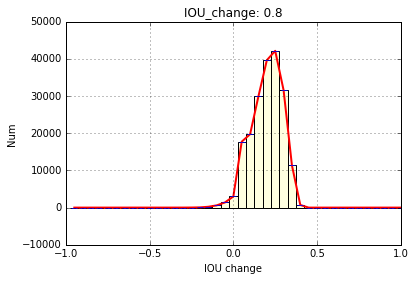

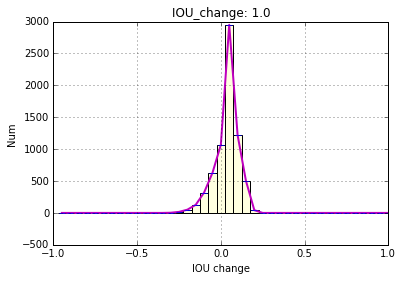

In [8]:
# %load IOU_change_curve.py
import sys
reload(sys)
sys.setdefaultencoding('utf8')
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.cElementTree as et
import scipy.io

"""
@function:从xml文件中读取box信息
@param param1: xml文件
@return: boxes, width, height
"""
def readXML(xml_name):
    tree = et.parse(xml_name) #打开xml文档
    # 得到文档元素对象
    root = tree.getroot()
    size = root.find('size')  # 找到root节点下的size节点
    width = size.find('width').text  # 子节点下节点width的值
    height = size.find('height').text  # 子节点下节点height的值

    boundingBox = []
    for object in root.findall('object'):  # 找到root节点下的所有object节点
        bndbox = object.find('bndbox')  # 子节点下属性bndbox的值
        xmin = bndbox.find('xmin').text
        ymin = bndbox.find('ymin').text
        xmax = bndbox.find('xmax').text
        ymax = bndbox.find('ymax').text
        boundingBox.append([int(xmin), int(ymin), int(xmax), int(ymax)])
    return boundingBox, width, height

"""
@function:计算两个box的IOU
@param param1: box1
@param param2: box2
@return: IOU
"""
def computIOU(A, B):
    W = min(A[2], B[2]) - max(A[0], B[0])
    H = min(A[3], B[3]) - max(A[1], B[1])
    if (W <= 0 or H <= 0):
        return 0
    SA = (A[2] - A[0]) * (A[3] - A[1])
    SB = (B[2] - B[0]) * (B[3] - B[1])
    cross = W * H
    iou = float(cross) / (SA + SB - cross)
    return iou

"""
@function:将匹配合并结果和检测结果比较回归IOU变化
@param param1: 匹配合并列表文件
@param param2: 检测结果列表文件
@param param3: 待保存IOU变化文件
"""
def save_data(priorList, resultList, data_mat):
    with open(priorList) as fp1, open(resultList) as fp2: # 对于每个测试图片
        plt.close('all')
        for resultFile in fp2: # 每一行匹配数据 resultFile
            priorFile = fp1.readline() # 每一行检测数据 priorFile
            prior_datas = priorFile.strip().split('\t')
            result_datas = resultFile.strip().split('\t')
            img_name = ROOTDIR + prior_datas[0]
            xml_name = ROOTDIR + prior_datas[1]
            # image = plt.imread(img_name)
            # width = image.shape[1]
            # height = image.shape[0]
            true_boxes, width, height = readXML(xml_name) # 所有的ground truth boxes
            prior_IOU = []  # 训练时所有匹配的prior box与gt box的IOU
            prior_boxes = [] # 训练时所有匹配的prior box坐标 [[prior_box_index, [xmin, ymin, xmax, ymax]]...]
            gt_boxes = [] # 样本所有gt box坐标 [[gt_box_index, [xmin, ymin, xmax, ymax]]...]
            prior_boxes_total = int(prior_datas[2]) # 匹配box数量
            for i in range(0, prior_boxes_total, 1):
                prior_box_index = int(prior_datas[7 * i + 3]) # 当前匹配proir box序号（从0开始）
                gt_box_index = int(prior_datas[7 * i + 9]) # 当前匹配的gt box序号（从0开始）
                prior_box_coordinates = [float(prior_datas[7*i + 5]) * width, float(prior_datas[7*i + 6]) * height, float(prior_datas[7*i + 7]) * width, float(prior_datas[7*i + 8]) * height]
                prior_boxes.append([prior_box_index, prior_box_coordinates])
                gt_boxes.append([gt_box_index, true_boxes[gt_box_index]])
                prior_IOU.append(float(prior_datas[7*i + 4]))
            if(len(prior_IOU)!= len(prior_boxes) or len(prior_IOU)!= len(gt_boxes)):
                print "匹配维度不统一！"
                break

            result_boxes = [] # 所有prior box的回归结果
            result_IOU = []  # result box与gt box的IOU
            reslut_conf = []  # 检测得到result box置信度
            result_boxes_total = (len(result_datas)-1)/6  # 检测得到的box数量
            for j in range(0, result_boxes_total, 1):
                result_box_index = int(result_datas[6 * j + 1])  # 当前匹配proir box序号（从0开始）
                result_box_coordinates = [float(result_datas[6 * j + 3]) * width, float(result_datas[6 * j + 4]) * height,
                                         float(result_datas[6 * j + 5]) * width, float(result_datas[6 * j + 6]) * height]
                result_boxes.append([result_box_index, result_box_coordinates])
                result_IOU.append(computIOU(gt_boxes[j][1], result_box_coordinates))
                reslut_conf.append(float(result_datas[6 * j + 2]))

            change_IOU = np.subtract(result_IOU, prior_IOU) # IOU变化
            for index in range(0, len(change_IOU), 1):
                div = int(prior_IOU[index] / min_threshold) # 落在哪个IOU区间
                scope = len(change_scope)/2 + int(change_IOU[index] / min_scope) # IOU变化区间
                all_change_group[div][scope] += 1

    scipy.io.savemat(data_mat, mdict={'IOU_change_statistic': all_change_group})

"""
@function:为直方图添加y轴信息
"""
def autolabel(rects, Num=1.12, rotation1=90, NN=1):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() - 0.01 + rect.get_width() / 2., Num * height, '%s' % int(height * NN),
                 rotation=rotation1)

"""
@function:将IOU变化以图形形式展现
@param param1: IOU变化文件
"""
def show_hist(data_mat):
    all_change_group = scipy.io.loadmat(data_mat)
    all_change_group = all_change_group['IOU_change_statistic']
    color = ['k', 'b', 'g', 'r', 'm']
    for i in range(0, len(all_change_group), 1):
        #plt.subplot(151+i) # 放在一个图片里显示
        plt.subplots(1)
        plt.plot(change_scope, all_change_group[i], lw=2,color=color[i])
        rects = plt.bar(left=change_scope, height=all_change_group[i], color='lightyellow',
                        width=0.05, align="center", yerr=0.000001)
        #autolabel(rects, 1.0) # 为每个直方图加标注
        plt.xlim((-1, 1))
        plt.title('IOU_change: '+ '%.1f' % thresholds[i])
        plt.ylabel('Num')
        plt.xlabel('IOU change')
        plt.grid()
    plt.show()

#matplotlib.rcParams['figure.figsize'] = (6, 8)  # 设定显示大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
min_threshold = 0.2
thresholds = np.linspace( min_threshold, 1, 5 ) # IOU 区间
min_scope = 0.05
change_scope = np.arange( -0.95, 1.01, min_scope ) # IOU变化区间
all_change_group = [[0 for x in range(len(change_scope))] for y in range(len(thresholds))] # 初始化为0

ROOTDIR = "\\\\192.168.1.186/PedestrianData/" # 样本所在根目录

if __name__ == "__main__":
#     save_data("../Data_0810/IOU_ALL_image_List.txt",
#               "../Data_0810/result_ALL_image_List.txt",
#               "../Data_0810/IOU_change_curve.mat")
    show_hist("../Data_0810/IOU_change_curve.mat")

### 3.2 绘制prior box分类recall曲线
prior box在训练中都被当成正样本来训练的，但实际检测中需要将prior box通过检测网络后的分类置信度与分类阈值做比较来判断该prior box是目标还是背景。**<font color='red'>confidence_change_curve.py</font>**将不同的分类置信阈值下的统计结果(TP、NP)按顺序保存在子表格中存在**<font color='red'>confidence_change_with_IOU_statistic.xlsx</font>**里。随后代码读取表格文件绘制各个分类置信阈值条件下分类recall曲线。

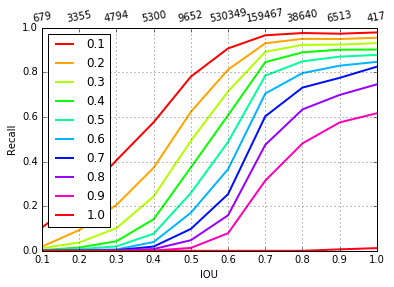

In [4]:
# %load confidence_change_curve.py
import sys
reload(sys)
sys.setdefaultencoding('utf8')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from openpyxl import Workbook
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

"""
@function:将匹配合并结果和检测结果比较分类confidence变化
@param param1: 匹配合并列表文件
@param param2: 检测结果列表文件
@param param3: 待保存confidence变化文件
"""
def save_data(priorList, resultList, data_xlsx):
    with open(priorList) as fp1, open(resultList) as fp2: # 对于每个测试图片
        for resultFile in fp2: # 每一行匹配数据 resultFile
            priorFile = fp1.readline() # 每一行检测数据 priorFile
            prior_datas = priorFile.strip().split('\t')
            result_datas = resultFile.strip().split('\t')

            prior_IOU = []  # 训练时所有匹配的prior box与gt box的IOU
            prior_boxes_total = int(prior_datas[2]) # 匹配box数量
            for i in range(0, prior_boxes_total, 1):
                prior_IOU.append(float(prior_datas[7*i + 4]))

            # reslut_conf = []  # 检测得到result box置信度
            result_boxes_total = (len(result_datas)-1)/6  # 检测得到的box数量
            for j in range(0, result_boxes_total, 1): # 对于每个prior box
                # index = int(prior_IOU[j] / thresholds[0])
                for i in range(0, len(thresholds), 1): # 判断IOU区间段
                    if (prior_IOU[j] < thresholds[i]):
                        index = i
                        break
                conf = float(result_datas[6 * j + 2]) #分类置信度
                for k in range(0, len(conf_thresholds), 1):  # 对于每个分类置信阈值
                    if conf >= conf_thresholds[k]:
                        all_change_group[k][index]['Pos'] += 1
                    else:
                        all_change_group[k][index]['Neg']  += 1

        # 将all_change_group数据写入xlsx表格中
        # 在内存中创建一个workbook对象，而且会至少创建一个 worksheet
        wb = Workbook()
        for k in range(0, len(conf_thresholds), 1):
            # 获取当前活跃的worksheet,默认就是第一个worksheet
            ws = wb.create_sheet()
            # 设置单元格的值，A1等于6(测试可知openpyxl的行和列编号从1开始计算)，B1等于7
            ws.cell(row=1, column=1).value = 'IOU'
            ws.cell("B1").value = 'Status'
            ws.cell("C1").value = 'NUM'
            # 从第1列第2行开始，写入IOU区间值
            for row in range(1, len(thresholds) + 1):
                ws.cell(row=row * 2, column=1).value = (thresholds[row - 1])
                ws.cell(row=row * 2 + 1, column=1).value = (thresholds[row - 1])
            # 从第2列第2行开始，写入Status值
            for row in range(1, len(thresholds) + 1):
                ws.cell(row=row * 2, column=2).value = 'Neg'
                ws.cell(row=row * 2 + 1, column=2).value = "Pos"
            # 从第3列第2行开始，写入NUM数据
            for row in range(1, len(thresholds) + 1):
                ws.cell(row=row * 2, column=3).value = all_change_group[k][row - 1]['Neg']
                ws.cell(row=row * 2 + 1, column=3).value = all_change_group[k][row - 1]['Pos']
        wb.save(filename=data_xlsx)


"""
@function:将各个conf阈值条件下confidence的变化以recall曲线展现
@param param1: confidence变化文件
"""
def show_curve(data_xlsx):
    fig1, ax1 = plt.subplots(1)
    prior_num = []
    for k in range(0, len(conf_thresholds), 1):
        recalls = []
        sheet_name = 'Sheet'+ str(k+1)
        df = pd.read_excel(data_xlsx, sheet_name)
        var = list(df['NUM'])
        for j in range(0, len(thresholds), 1):
            if k==0:
                prior_num.append(var[2*j+1] + var[2*j])
            recall = float(var[2*j+1]) / (float(var[2*j+1]) + float(var[2*j]))
            recalls.append(recall)
        ax1.plot(thresholds, recalls, lw=2, color=colors[k], label=str(conf_thresholds[k])) # 绘制每一条recall曲线
        # plt.annotate(conf_thresholds[k], xy=(thresholds[len(thresholds)/2], recalls[len(recalls)/2]),
        #              xytext=(thresholds[len(thresholds)/2], recalls[len(recalls)/2]),
        #              arrowprops = dict(facecolor="r", headlength=5, headwidth=5, width=2))

    plt.grid()
    plt.xlabel('IOU')
    plt.ylabel('Recall')
    #plt.title('IOU-Recall')
    plt.legend(loc="upper left")
    ax2 = ax1.twiny()
    ax2.set_xlim(0.1, 1)
    plt.xticks(thresholds, prior_num, rotation=10)
    plt.show()

#matplotlib.rcParams['figure.figsize'] = (6, 8)  # 设定显示大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
colors = plt.cm.hsv(np.linspace(0, 1, 10)).tolist()
ROOTDIR = "\\\\192.168.1.186/PedestrianData/" # 样本根目录
min_threshold = 0.1 # 最小IOU区间
thresholds = np.linspace( min_threshold, 1, 10 ) # IOU 区间
min_conf_threshold = 0.1 # 最小分类置信度阈值
conf_thresholds = np.linspace( min_conf_threshold, 1, 10 ) # 分类置信度阈值
all_change_group =  [[] for x in range(len(conf_thresholds))]  # 初始化
for j in range(0, len(conf_thresholds), 1):
    for i in range(0, len(thresholds), 1):
        all_change_group[j].append({'Neg': 0, 'Pos': 0})


if __name__ == "__main__":
    # save_data("../Data_0810/IOU_ALL_image_List.txt",
    #           "../Data_0810/result_ALL_image_List.txt",
    #           "../Data_0810/confidence_change_with_IOU_statistic.xlsx")
    show_curve("../Data_0810/confidence_change_with_IOU_statistic.xlsx")

## 4 以目标大小为基准检查训练中prior box分类、回归情况
这里，我们要调查的是不同的大小的目标对于prior box匹配分类和回归的影响。

从流程上，首先将所有的ground truth boxes按照面积比进行分组。然后将每一组的ground truth boxes对应的prior boxes按照IOU区间进行分组。划分结束后统计每个组中prior box经过模型后的分类recall和回归情况。

代码**<font color='red'>object_confidence_IOU_change_curve.py</font>**中子函数save_data()将同时读取匹配列表IOU_ALL_image_List.txt和检测结果result_ALL_image_List.txt。统计结束后将统计数据保存在代码 **<font color='red'>object_confidence_IOU_change_curve.mat</font>**文件中。子函数draw_curve()读取mat统计数据后绘制IOU改变直方图和recall曲线。

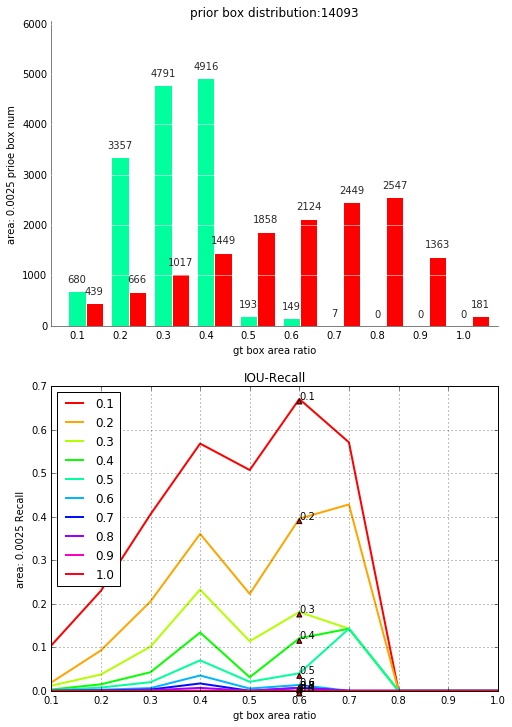

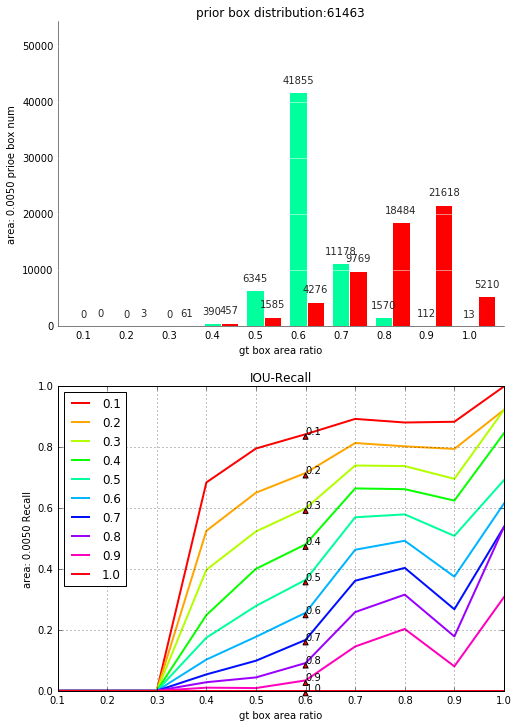

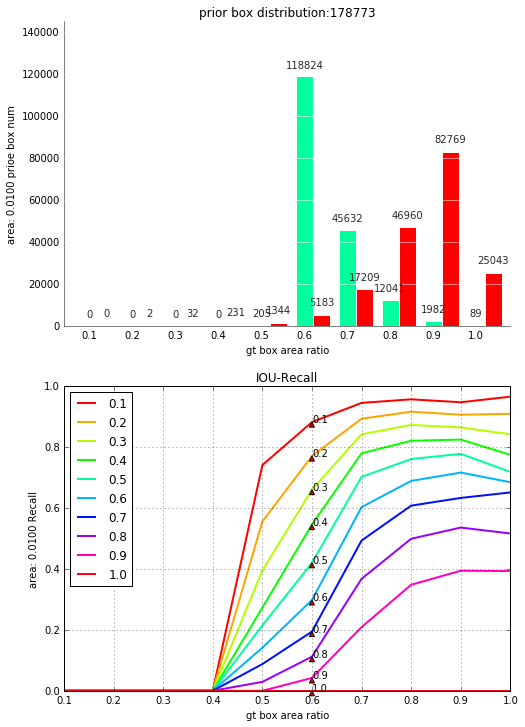

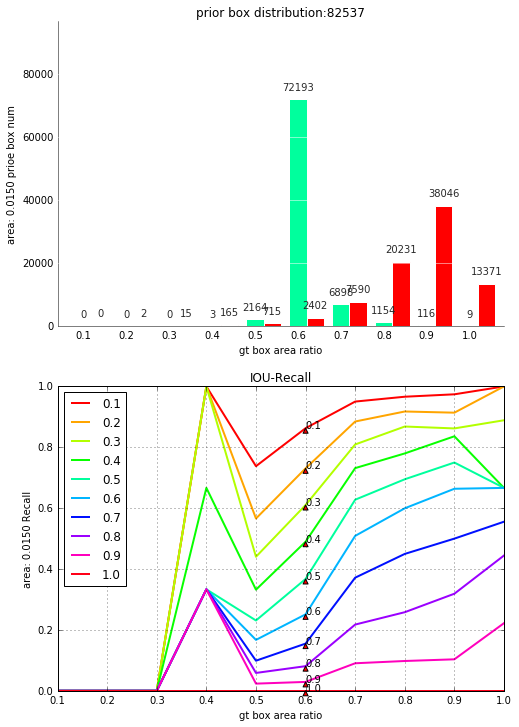

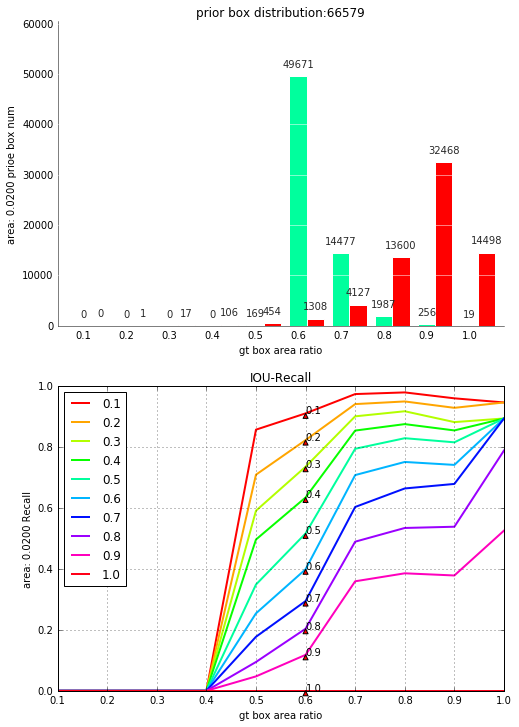

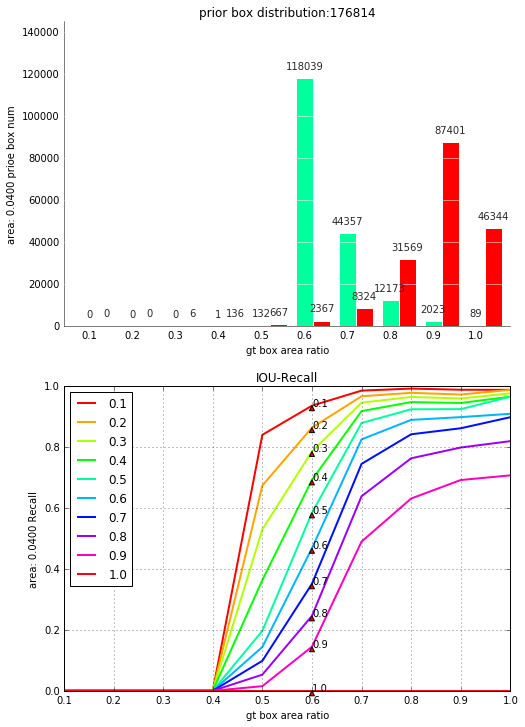

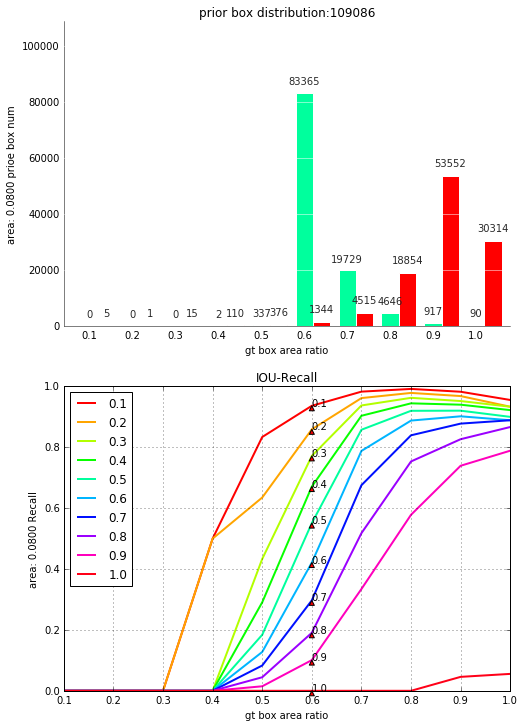

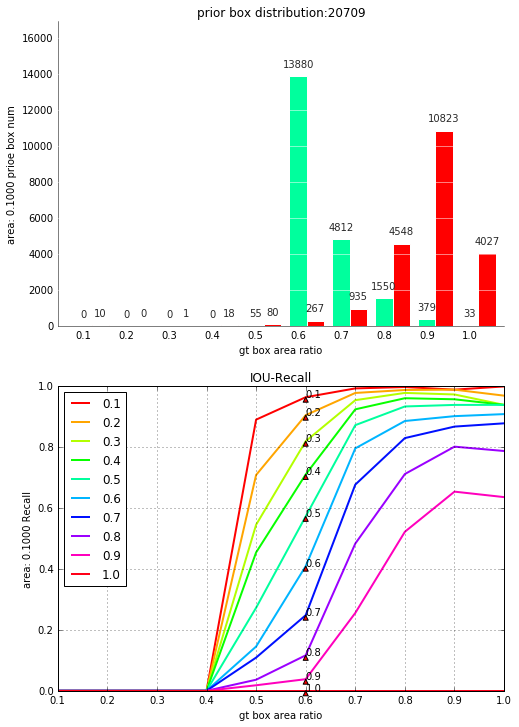

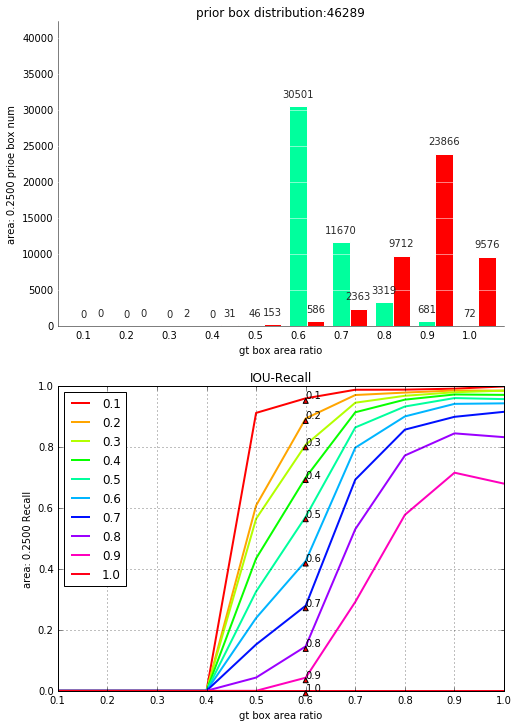

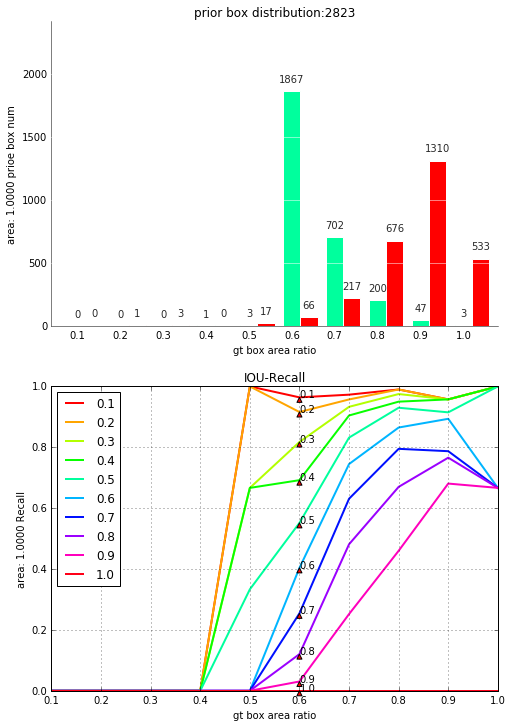

In [13]:
# %load object_confidence_IOU_change_curve.py
import numpy as np
import pylab as plt
import prettyplotlib as ppl
import xml.etree.cElementTree as et
import scipy.io

"""
@function:计算两个box的IOU
@param param1: box1
@param param2: box2
@return: IOU
"""
def computIOU(A, B):
    W = min(A[2], B[2]) - max(A[0], B[0])
    H = min(A[3], B[3]) - max(A[1], B[1])
    if (W <= 0 or H <= 0):
        return 0
    SA = (A[2] - A[0]) * (A[3] - A[1])
    SB = (B[2] - B[0]) * (B[3] - B[1])
    cross = W * H
    iou = float(cross) / (SA + SB - cross)
    return iou

"""
@function:从xml文件中读取box信息
@param param1: xml文件
@return: boxes
"""
def readXML(xml_name):
    tree = et.parse(xml_name) #打开xml文档
    # 得到文档元素对象
    root = tree.getroot()
    size = root.find('size')  # 找到root节点下的size节点
    width = int(size.find('width').text)  # 子节点下节点width的值
    height = int(size.find('height').text)  # 子节点下节点height的值

    boundingBox = []
    for object in root.findall('object'):  # 找到root节点下的所有object节点
        bndbox = object.find('bndbox')  # 子节点下属性bndbox的值
        xmin = bndbox.find('xmin').text
        ymin = bndbox.find('ymin').text
        xmax = bndbox.find('xmax').text
        ymax = bndbox.find('ymax').text
        boundingBox.append([int(xmin), int(ymin), int(xmax), int(ymax)])
    return boundingBox, width, height

"""
@function:将匹配合并结果和检测结果比较分类confidence变化
@param param1: 匹配合并列表文件
@param param2: 检测结果列表文件
@param param3: 待保存mat矩阵
"""
def save_data(priorList, resultList, data_mat):
    with open(priorList) as fp1, open(resultList) as fp2:  # 对于每个测试图片
        for priorFile in fp1:  # 每一行匹配数据 resultFile
            resultFile = fp2.readline()  # 每一行检测数据 priorFile
            prior_datas = priorFile.strip().split('\t')
            result_datas = resultFile.strip().split('\t')
            xml_name = ROOTDIR + prior_datas[1]

            # 1.记录各个gt box面积占比
            true_boxes, width, height = readXML(xml_name)  # 所有的ground truth boxes
            gt_areas = []
            gt_box_index = 0
            for gt_box in true_boxes:
                area_ratio = float((gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])) / (width * height)
                gt_areas.append([gt_box_index, area_ratio])
                gt_box_index += 1

            # 2.记录各个prior box匹配IOU、分类conf和回归IOU
            prior_IOU = []  # 训练时所有匹配的prior box与gt box的IOU
            prior_conf = []  # 训练时所有匹配的prior box与gt box的IOU
            prior_boxes_total = int(prior_datas[2])  # 匹配box数量
            result_IOU = []  # result box与gt box的IOU
            # total_prior_num += prior_boxes_total
            for i in range(0, prior_boxes_total, 1):
                gt_box_index = int(prior_datas[7 * i + 9])  # 当前匹配的gt box序号（从0开始）
                IOU = float(prior_datas[7 * i + 4])
                prior_IOU.append([gt_box_index, IOU])
                conf = float(result_datas[6 * i + 2])  # 分类置信度
                prior_conf.append([gt_box_index, conf])
                result_box_coordinates = [float(result_datas[6 * i + 3]) * width, float(result_datas[6 * i + 4]) * height,
                                          float(result_datas[6 * i + 5]) * width, float(result_datas[6 * i + 6]) * height]
                result_IOU.append([gt_box_index, computIOU(true_boxes[gt_box_index], result_box_coordinates)])

            # 3.按照area和匹配IOU统计划分
            for n in range(0, prior_boxes_total, 1):  # 对于每个prior box
                    for area_i in range(0, len(area_thresholds), 1):  # 判断area区间段
                        if (gt_areas[prior_IOU[n][0]][1] <= area_thresholds[area_i]):
                            area_index = area_i
                            break
                    for IOU_i in range(0, len(IOU_thresholds), 1):  # 判断IOU区间段
                        if (prior_IOU[n][1] <= IOU_thresholds[IOU_i]):
                            IOU_index = IOU_i
                            break
                    for IOU_i in range(0, len(IOU_thresholds), 1):  # 判断IOU区间段
                        if (result_IOU[n][1] <= IOU_thresholds[IOU_i]):
                            rIOU_index = IOU_i
                            break
                    area_prior_num[area_index][IOU_index] += 1
                    area_result_num[area_index][rIOU_index] += 1
                    for conf_i in range(0, len(conf_thresholds), 1):  # 对于每个分类置信阈值
                        if prior_conf[n][1] >= conf_thresholds[conf_i]:
                            all_change_group[area_index][conf_i][IOU_index]['Pos'] += 1
                        else:
                            all_change_group[area_index][conf_i][IOU_index]['Neg'] += 1
    # 3.将数据保存
    scipy.io.savemat(data_mat, {'prior_rgression_statistic': prior_rgression_statistic, 'all_change_group': all_change_group})

"""
@function:
1.将gt boxes和prior boxes分布绘制
2.将各个conf阈值条件下confidence的变化以recall曲线展现
@param param1: gt boxes和prior boxes分布
@param param2: confidence变化文件
"""
def draw_curve(data_mat):
    data = scipy.io.loadmat(data_mat)
    prior_rgression_statistic = data['prior_rgression_statistic']
    area_prior_num = prior_rgression_statistic[0]
    area_result_num = prior_rgression_statistic[1]
    all_change_group = data['all_change_group']
    # 1. 绘制gt boxes和prior boxes分布
    for pl in range(0, len(area_thresholds), 1):
        total_prior_num = 0
        for num in area_prior_num[pl]:
            total_prior_num += num
        fig, axes = plt.subplots(nrows=2, figsize=(8, 12))
        strand_names = 'prior box distribution:%d' % total_prior_num
        yalbel_names = 'area: ' + '%.4f' % area_thresholds[pl] + ' prioe box num'
        labels = [IOU_thresholds[i] for i in s_ids]
        ppl.bar(axes[0], s_ids, area_prior_num[pl],
                annotate=True,width = 0.4,
                grid='y', xticklabels=labels,
                color=colors[4]) #color=[colors[i] for i in s_ids]
        ppl.bar(axes[0], s_ids+0.4, area_result_num[pl],
                annotate=True,width = 0.4,
                grid='y',
                color=colors[0])
        axes[0].set_title(strand_names)
        axes[0].set_ylabel(yalbel_names)
        axes[0].set_xlabel('gt box area ratio')

        # 2. 绘制不同confidence阈值下的recall曲线
        prior_num = []
        for conf_i in range(0, len(conf_thresholds), 1):
            recalls = []
            for j in range(0, len(IOU_thresholds), 1):
                if conf_i == 0:
                    prior_num.append(all_change_group[pl][conf_i][j]['Neg'] + all_change_group[pl][conf_i][j]['Pos'])
                TP = float(all_change_group[pl][conf_i][j]['Pos'])
                FP = float(all_change_group[pl][conf_i][j]['Neg'])
                if TP == 0:
                    recall = 0
                else:
                    recall = TP / (TP + FP)
                recalls.append(recall)
            axes[1].plot(s_ids, recalls, lw=2, color=colors[conf_i],
                         label=str(conf_thresholds[conf_i]))  # 绘制每一条recall曲线
            plt.annotate(conf_thresholds[conf_i], xy=(s_ids[len(s_ids) / 2], recalls[len(recalls) / 2]),
                         xytext=(s_ids[len(s_ids) / 2], recalls[len(recalls) / 2]),
                         arrowprops=dict(facecolor="r", headlength=5, headwidth=5, width=2))
        plt.grid()
        plt.xticks(s_ids, IOU_thresholds)
        plt.xlabel('gt box area ratio')
        plt.ylabel('area: ' + '%.4f' % area_thresholds[pl] + ' Recall')
        plt.title('IOU-Recall')
        plt.legend(loc="upper left")
        # ax2 = axes[1].twiny()
        # plt.xticks(s_ids, prior_num, rotation=10)
    plt.show()

ROOTDIR = "\\\\192.168.1.186/PedestrianData/" # 样本所在根目录
min_conf_threshold = 0.1 # 最小分类置信度阈值
conf_thresholds = np.linspace( min_conf_threshold, 1, 10 ) # 分类置信度阈值
min_threshold = 0.1 # 最小IOU区间
IOU_thresholds = np.linspace( min_threshold, 1, 10 ) # IOU 区间
area_thresholds = np.array([0.0025, 0.005, 0.01, 0.015, 0.02, 0.04, 0.08, 0.1, 0.25, 1.0],dtype=np.float64) # area 区间
area_prior_num = np.zeros((len(area_thresholds), len(IOU_thresholds)),dtype=np.int32)
area_result_num = np.zeros((len(area_thresholds), len(IOU_thresholds)),dtype=np.int32)
prior_rgression_statistic = []
prior_rgression_statistic.append(area_prior_num)
prior_rgression_statistic.append(area_result_num)
all_change_group =  [[[] for x in range(len(conf_thresholds))] for y in range(len(area_thresholds))]  # 初始化
for k in range(0, len(area_thresholds), 1):
    for j in range(0, len(conf_thresholds), 1):
        for i in range(0, len(IOU_thresholds), 1):
            all_change_group[j][i].append({'Neg': 0, 'Pos': 0})
s_ids = np.arange(len(IOU_thresholds))
colors = plt.cm.hsv(np.linspace(0, 1, 10)).tolist()

if __name__ == "__main__":
    # save_data("../Data_0810/IOU_ALL_image_List.txt",
    #           "../Data_0810/result_ALL_image_List.txt",
    #           "../Data_0810/object_confidence_IOU_change_curve.mat")
    draw_curve("../Data_0810/object_confidence_IOU_change_curve.mat")